In [23]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
import scipy
from scipy.stats import poisson, binom, beta
from scipy.optimize import minimize
from scipy.optimize import minimize, NonlinearConstraint

### 1st step - Possession

### CHANGED FOR BETA

$$
P^h \sim Normal(0.5 + K^h, \sigma^2)
$$

$$
K^h = \Gamma^h + \Gamma^{HA} - \Gamma^a
$$



In [26]:
data = pd.read_csv('3_step_data.csv', sep=',')

In [25]:
data = pd.read_csv('brazil_2018.csv', sep=',')

In [4]:
data = pd.read_csv('brazil_b_2018.csv', sep=',')

In [27]:
data

,home,away,home_goal,away_goal,home_shots,away_shots,home_possession,away_possession
0,Manchester United,Leicester City,2,1,8,8,0.46,0.54
1,Newcastle United,Tottenham Hotspur,1,2,11,13,0.40,0.60
2,AFC Bournemouth,Cardiff City,2,0,11,7,0.62,0.38
3,Fulham,Crystal Palace,0,2,11,11,0.66,0.34
4,Huddersfield Town,Chelsea,0,3,6,8,0.37,0.63
...,...,...,...,...,...,...,...,...
375,Liverpool,Wolverhampton Wanderers,2,0,11,7,0.59,0.41
376,Manchester United,Cardiff City,0,2,21,11,0.73,0.27
377,Southampton,Huddersfield Town,1,1,7,8,0.53,0.47
378,Tottenham Hotspur,Everton,2,2,9,13,0.55,0.45


In [95]:
teams = pd.unique(data[['home', 'away']].values.ravel('K'))
teams_params = pd.DataFrame({
    'Team': teams,
    'gamma': 1,
    'alpha': 10,
    'beta': 3,
    'delta':0.8,
    'zeta': 0.2
})

teams_params.set_index('Team', inplace=True)

In [96]:
hyper_params = {
    'gamma_ha': 0.5,
    'sigma': 2,
    'alpha_ha':1
}

In [97]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,1,10,3,0.8,0.2
Newcastle United,1,10,3,0.8,0.2
AFC Bournemouth,1,10,3,0.8,0.2
Fulham,1,10,3,0.8,0.2
Huddersfield Town,1,10,3,0.8,0.2
Watford,1,10,3,0.8,0.2
Wolverhampton Wanderers,1,10,3,0.8,0.2
Liverpool,1,10,3,0.8,0.2
Southampton,1,10,3,0.8,0.2


In [98]:
hyper_params

{'gamma_ha': 0.5, 'sigma': 2, 'alpha_ha': 1}

In [99]:
n_train = 150
n_validation = 200

data_train = data[:n_train]
data_validation = data[n_train:n_validation]
data_test = data[n_validation:]


In [100]:
def poss_log_likelihood(params, data, team=None):

    gamma_ha = params[-2]
    sigma = params[-1]
    params = params[:-2]


    teams_params = pd.DataFrame({
        'Team': team,
        'gamma': params}).set_index('Team')
    
    total_sum = 0


    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_poss = row['home_possession']
        away_poss = row['away_possession']

        
        gamma_h = teams_params.at[name_h, 'gamma']
        gamma_a = teams_params.at[name_a, 'gamma']
        
        kh = np.exp(gamma_h + gamma_ha - gamma_a)
        #kh = np.exp(gamma_h + gamma_ha - gamma_a)
        

        row_sum = scipy.stats.beta.logpdf(home_poss, kh, sigma)
        #row_sum = scipy.stats.beta.logpdf(home_poss, sigma, sigma*kh)
        total_sum += row_sum
    
    return -total_sum.tolist()

In [101]:
# Initial guess
initial_params = teams_params.gamma.values.T.flatten().tolist() + [hyper_params['gamma_ha'], hyper_params['sigma']]  # Flatten alpha and beta, and add initial gamma

In [102]:
poss_log_likelihood(initial_params, data_train, teams_params.index.tolist())

-37.960855815877444

In [109]:
# Bounds for
gamma1, gamma2 = 0.0, 5
gammaha1, gammaha2 = 0.0, 5
sigma1, sigma2 = 0.01, 30
bounds = [(gamma1, gamma2)] * len(teams) + [(gammaha1, gammaha2)] + [(sigma1, sigma2)]


# Optimize
result = minimize(poss_log_likelihood, initial_params, args=(data_train, teams), bounds=bounds, options={'maxiter': 100}) #, constraints=constraints)

In [110]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -186.76040164198275
        x: [ 1.099e+00  4.783e-01 ...  3.166e+00  2.236e+01]
      nit: 23
      jac: [ 1.251e-04  6.025e-04 ... -3.951e-03  1.535e-04]
     nfev: 644
     njev: 28
 hess_inv: <22x22 LbfgsInvHessProduct with dtype=float64>

In [111]:
optimized_params = result.x
optimized_gamma_ha = optimized_params[-2]
optimized_sigma = optimized_params[-1]
optimized_gammas = optimized_params[:len(teams)]

In [112]:
hyper_params['gamma_ha'] = optimized_gamma_ha
hyper_params['sigma'] = optimized_sigma
teams_params.gamma = optimized_gammas

In [113]:
hyper_params

{'gamma_ha': 3.16647588484575, 'sigma': 22.361446670562607, 'alpha_ha': 1}

In [208]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,1.191648,23.712108,3.876058,0.893698,0.714048
Newcastle United,0.616396,27.076319,7.035955,0.824646,0.774576
AFC Bournemouth,0.867408,25.023999,5.525066,0.903481,0.733158
Fulham,0.933333,25.845727,1.421693,0.820340,0.687036
Huddersfield Town,0.847206,24.347253,7.442669,0.810996,0.711676
Watford,0.835199,24.761419,9.277963,0.858308,0.722674
Wolverhampton Wanderers,0.863807,30.000000,8.966972,0.824789,0.734175
Liverpool,1.420414,24.732092,9.055194,0.890602,0.810996
Southampton,0.823598,29.766929,7.106571,0.810996,0.691457


In [209]:
def shot_log_likelihood(params, data, team=None):

    alpha_ha = params[-1]
    params = params[:-1]


    teams_params = pd.DataFrame({
        'Team': team,
        'alpha': params[:len(team)],
        'beta': params[len(team):]}).set_index('Team')
    
    total_sum = 0


    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_poss = row['home_possession']
        away_poss = row['away_possession']
        home_shots = row['home_shots']
        away_shots = row['away_shots']

        
        alpha_h = teams_params.at[name_h, 'alpha']
        beta_h = teams_params.at[name_h, 'beta']

        alpha_a = teams_params.at[name_a, 'alpha']
        beta_a = teams_params.at[name_a, 'beta']
        
        lambda_h = alpha_ha + alpha_h - beta_a
        lambda_a = alpha_a - beta_h


        row_sum = poisson.logpmf(home_shots, lambda_h*home_poss) + poisson.logpmf(away_shots, lambda_a*away_poss) 
        total_sum += row_sum
    
    return -total_sum.tolist()

In [210]:
# Initial guess
initial_params = teams_params[['alpha', 'beta']].values.T.flatten().tolist() + [hyper_params['alpha_ha']]  # Flatten alpha and beta, and add initial gamma

In [211]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,1.191648,23.712108,3.876058,0.893698,0.714048
Newcastle United,0.616396,27.076319,7.035955,0.824646,0.774576
AFC Bournemouth,0.867408,25.023999,5.525066,0.903481,0.733158
Fulham,0.933333,25.845727,1.421693,0.820340,0.687036
Huddersfield Town,0.847206,24.347253,7.442669,0.810996,0.711676
Watford,0.835199,24.761419,9.277963,0.858308,0.722674
Wolverhampton Wanderers,0.863807,30.000000,8.966972,0.824789,0.734175
Liverpool,1.420414,24.732092,9.055194,0.890602,0.810996
Southampton,0.823598,29.766929,7.106571,0.810996,0.691457


In [212]:
shot_log_likelihood(initial_params, data_train, teams_params.index.tolist())

738.1505297223844

In [213]:
# Define the constraint functions for a_i > b_j for all i, j
def constraint(params):
    n = int((len(params)-1)/2)
    a = params[:n]
    b = params[n:2*n]
    c = params[-1]
    constraints = []
    for ai in a:
        for bj in b:
            constraints.append(ai - bj)
    return constraints

constraints = {
    'type': 'ineq',  # 'ineq' means the constraint function should be non-negative
    'fun': lambda params: np.array(constraint(params))
}

In [214]:
# Bounds for alpha, beta, and home adv alpha
a1, a2 = 0, 30.0  # Bounds for alpha
b1, b2 = 0.0, 10.0  # Bounds for beta
c1, c2 = 0.0, 10.0  # Bounds for gamma
bounds = [(a1, a2)] * len(teams) + [(b1, b2)] * len(teams) + [(c1, c2)]



# Optimize
result = minimize(shot_log_likelihood, initial_params, args=(data_train, teams), bounds=bounds, constraints=constraints, options={'maxiter': 100})

In [215]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 738.1505297223844
       x: [ 2.371e+01  2.708e+01 ...  8.722e+00  2.753e+00]
     nit: 1
     jac: [ 6.866e-05 -2.289e-05 ... -9.155e-05  6.714e-04]
    nfev: 42
    njev: 1

In [216]:
optimized_params = result.x
optimized_alpha_ha = optimized_params[-1]
optimized_alphas = optimized_params[:len(teams)]
optimized_betas = optimized_params[len(teams):2*len(teams)]

In [217]:
hyper_params['alpha_ha'] = optimized_alpha_ha
teams_params.alpha = optimized_alphas
teams_params.beta = optimized_betas

In [218]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,1.191648,23.712108,3.876058,0.893698,0.714048
Newcastle United,0.616396,27.076319,7.035955,0.824646,0.774576
AFC Bournemouth,0.867408,25.023999,5.525066,0.903481,0.733158
Fulham,0.933333,25.845727,1.421693,0.820340,0.687036
Huddersfield Town,0.847206,24.347253,7.442669,0.810996,0.711676
Watford,0.835199,24.761419,9.277963,0.858308,0.722674
Wolverhampton Wanderers,0.863807,30.000000,8.966972,0.824789,0.734175
Liverpool,1.420414,24.732092,9.055194,0.890602,0.810996
Southampton,0.823598,29.766929,7.106571,0.810996,0.691457


In [219]:
hyper_params

{'gamma_ha': 3.16647588484575,
 'sigma': 22.361446670562607,
 'alpha_ha': 2.7527440287281153}

In [220]:
def goal_log_likelihood(params, data, team=None):


    teams_params = pd.DataFrame({
        'Team': team,
        'delta': params[:len(team)],
        'zeta': params[len(team):]}).set_index('Team')
    
    total_sum = 0


    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_shots = row['home_shots']
        away_shots = row['away_shots']
        home_goal = row['home_goal']
        away_goal = row['away_goal']

        
        delta_h = teams_params.at[name_h, 'delta']
        zeta_h = teams_params.at[name_h, 'zeta']

        delta_a = teams_params.at[name_a, 'delta']
        zeta_a = teams_params.at[name_a, 'zeta']
        
        pg_h = delta_h - zeta_a
        pg_a = delta_a - zeta_h

        
        row_sum = binom.logpmf(home_goal, home_shots, pg_h) + binom.logpmf(away_goal, away_shots, pg_a)
        total_sum += row_sum
    
    return -total_sum.tolist()

In [221]:
def goal_log_likelihood(params, data, team=None):


    teams_params = pd.DataFrame({
        'Team': team,
        'delta': params[:len(team)],
        'zeta': params[len(team):]}).set_index('Team')
    
    total_sum = 0


    
    for _, row in data.iterrows():
        name_h = row['home']
        name_a = row['away']
        home_shots = row['home_shots']
        away_shots = row['away_shots']
        home_goal = row['home_goal']
        away_goal = row['away_goal']

        
        delta_h = teams_params.at[name_h, 'delta']
        zeta_h = teams_params.at[name_h, 'zeta']

        delta_a = teams_params.at[name_a, 'delta']
        zeta_a = teams_params.at[name_a, 'zeta']
        
        pg_h = delta_h - zeta_a
        pg_a = delta_a - zeta_h

        
        row_sum = poisson.logpmf(home_goal, home_shots*pg_h) + poisson.logpmf(away_goal, away_shots*pg_a)
        total_sum += row_sum
    
    return -total_sum.tolist()

In [222]:
# Initial guess
initial_params = teams_params[['delta', 'zeta']].values.T.flatten().tolist()  # Flatten alpha and beta, and add initial gamma

In [223]:
goal_log_likelihood(initial_params, data_train, teams_params.index.tolist())

399.08286396787184

In [224]:
# Define the constraint functions for a_i > b_j for all i, j
def constraint(params):
    n = int((len(params))/2)
    a = params[:n]
    b = params[n:2*n]
    constraints = []
    for ai in a:
        for bj in b:
            constraints.append(ai - bj)
    return constraints

constraints = {
    'type': 'ineq',  # 'ineq' means the constraint function should be non-negative
    'fun': lambda params: np.array(constraint(params))
}

In [225]:
# Bounds for delta, zeta
a1, a2 = 0, 3.0 
b1, b2 = 0.0, 2.0
bounds = [(a1, a2)] * len(teams) + [(b1, b2)] * len(teams)



# Optimize
result = minimize(goal_log_likelihood, initial_params, args=(data_train, teams), bounds=bounds, constraints=constraints, options={'maxiter': 100})

In [226]:
result

 message: Inequality constraints incompatible
 success: False
  status: 4
     fun: 399.08286396787184
       x: [ 8.937e-01  8.246e-01 ...  7.414e-01  7.285e-01]
     nit: 1
     jac: [-8.213e-02 -7.793e-01 ...  2.069e-01 -1.543e+00]
    nfev: 41
    njev: 1

In [227]:
optimized_params = result.x
optimized_delta = optimized_params[:len(teams)]
optimized_zeta = optimized_params[len(teams):2*len(teams)]

In [228]:
teams_params.delta = optimized_delta
teams_params.zeta = optimized_zeta

In [229]:
teams_params

,gamma,alpha,beta,delta,zeta
Team,,,,,
Manchester United,1.191648,23.712108,3.876058,0.893698,0.714048
Newcastle United,0.616396,27.076319,7.035955,0.824646,0.774576
AFC Bournemouth,0.867408,25.023999,5.525066,0.903481,0.733158
Fulham,0.933333,25.845727,1.421693,0.820340,0.687036
Huddersfield Town,0.847206,24.347253,7.442669,0.810996,0.711676
Watford,0.835199,24.761419,9.277963,0.858308,0.722674
Wolverhampton Wanderers,0.863807,30.000000,8.966972,0.824789,0.734175
Liverpool,1.420414,24.732092,9.055194,0.890602,0.810996
Southampton,0.823598,29.766929,7.106571,0.810996,0.691457


In [200]:
teams_params['gamma'].loc['Brighton & Hove Albion'] = 0.602361478

In [230]:
hyper_params

{'gamma_ha': 3.16647588484575,
 'sigma': 22.361446670562607,
 'alpha_ha': 2.7527440287281153}

In [231]:
def param_calculator(team_h, team_a, params, hyper_params):

    gamma_h, alpha_h, beta_h, delta_h, zeta_h = params.loc[team_h]
    gamma_a, alpha_a, beta_a, delta_a, zeta_a = params.loc[team_a]

    ## Possession
    gamma_ha = hyper_params['gamma_ha']
    sigma = hyper_params['sigma']
    alpha_ha = hyper_params['alpha_ha']

    kh = gamma_h + gamma_ha - gamma_a
    ka = gamma_a - gamma_h


    ## Shots
    lambda_h = alpha_ha + alpha_h - beta_a
    lambda_a = alpha_a - beta_h


    ## Goals
    pg_h = delta_h - zeta_a
    pg_a = delta_a - zeta_h



    return [kh, sigma, lambda_h, pg_h], [ka, sigma, lambda_a, pg_a]


In [232]:
import numpy as np
import scipy.stats as stats
from scipy.integrate import quad

def log_factorial(n):
    """ Compute the logarithm of the factorial of n. """
    return np.sum(np.log(np.arange(1, n + 1)))

def P_C(c, k, sigma, lambd, p):
    """
    Compute the probability P(C = c) for given parameters.
    
    Parameters:
    c (int): The value of C.
    k (float): The parameter k in the normal distribution of A.
    sigma (float): The standard deviation of the normal distribution of A.
    lambd (float): The rate parameter for the Poisson distribution of B given A.
    p (float): The probability parameter for the Binomial distribution of C given B.
    
    Returns:
    float: The probability P(C = c).
    """
    mean_a = 0.5 + k
    std_a = sigma
    lower_limit = max(mean_a - 5 * std_a, 0)
    upper_limit = mean_a + 5 * std_a
    
    # Define the integrand for the marginalization over A
    def integrand(a):
        if a <= 0:
            return 0
        # Normal distribution P(A)
        P_A = stats.norm.pdf(a, loc=mean_a, scale=std_a)
        # Binomial-Poisson mixture P(C | A)
        log_P_C_given_A = c * np.log(p) + c * np.log(lambd * a) - lambd * a * p - log_factorial(c)
        P_C_given_A = np.exp(log_P_C_given_A)
        return P_C_given_A * P_A
    
    # Perform the integration over A
    result, _ = quad(integrand, lower_limit, upper_limit)
    return result



In [139]:
ph, pa = param_calculator('Botafogo', 'Paraná', teams_params, hyper_params)

KeyError: 'Botafogo'

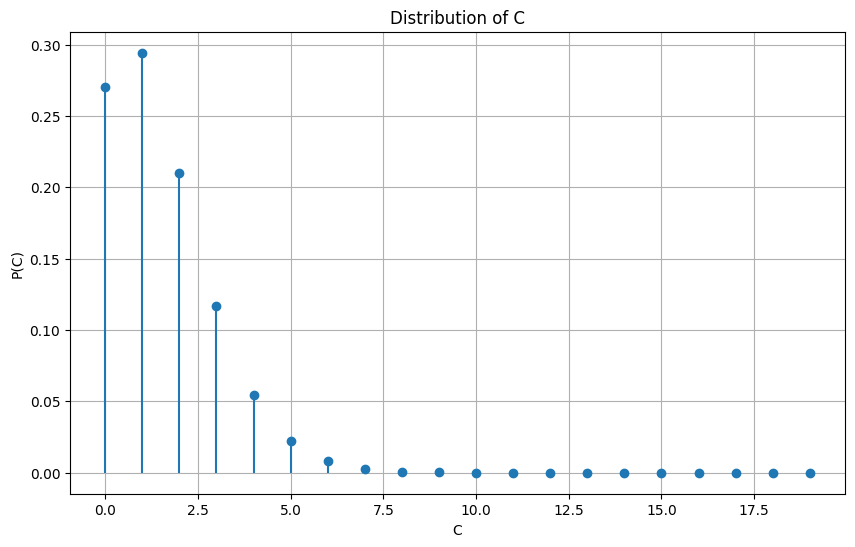

In [64]:
# Compute probabilities for a range of C values
C_values = np.arange(0, 20)
P_C_values = [P_C(c, *ph) for c in C_values]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.stem(C_values, P_C_values, basefmt=" ")
plt.xlabel('C')
plt.ylabel('P(C)')
plt.title('Distribution of C')
plt.grid(True)
plt.show()

In [65]:
ph, pa = param_calculator('Santos', 'Paraná', teams_params, hyper_params)

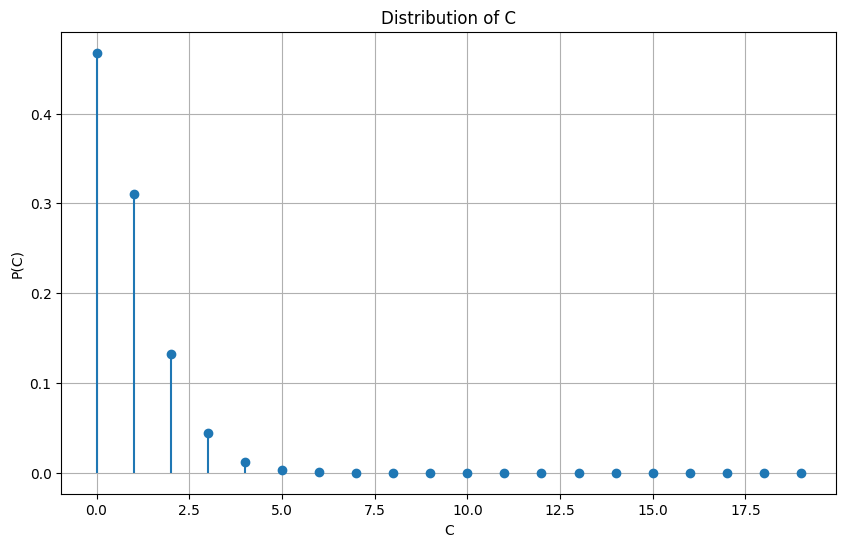

In [67]:
# Compute probabilities for a range of C values
C_values = np.arange(0, 20)
P_C_values = [P_C(c, *pa) for c in C_values]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.stem(C_values, P_C_values, basefmt=" ")
plt.xlabel('C')
plt.ylabel('P(C)')
plt.title('Distribution of C')
plt.grid(True)
plt.show()

In [233]:

matrix = []

# Assim não é perfeito pq não considera a (pequena) correlação negativa entre os gols de cada time.
# Precisaria realmente calcular P(G^h, G^a) = P(G^h)*P(G^a | G^h)

def results_probability(home_team, away_team, teams_params, hyper_params):
    
    w = 0
    d = 0
    l = 0

    s = 0

    ph, pa = param_calculator(home_team, away_team, teams_params, hyper_params)
    for i in range(8):
        line = []
        for j in range(8):
            p1 = P_C(i, *ph)
            p2 = P_C(j,*pa)
            p = p1 * p2
            s += p

            if i>j:
                w += p
            elif i == j:
                d += p
            else:
                l += p

        #matrix.append(line)

    #matrix = np.array(matrix)
    #sum_ = np.sum(matrix)
    w /= s
    d /= s
    l /= s

    return w, d, l

In [234]:
data_test_compare = data_test.copy()

In [235]:
for idx, row in data_test_compare.iterrows():
    name_h = row['home']
    name_a = row['away']


    win, draw, lose = results_probability(name_h, name_a, teams_params, hyper_params)

    home_goal = row['home_goal']
    away_goal = row['away_goal']

    rps_ = [win, draw, lose]

    if home_goal > away_goal:
        data_test_compare.loc[idx, 'outcome'] = 1
        rps_[0] -= 1 
    elif home_goal < away_goal:
        data_test_compare.loc[idx, 'outcome'] = -1
        rps_[2] -= 1 
    else:
        data_test_compare.loc[idx, 'outcome'] = 0
        rps_[1] -= 1

    rps = 0
    bs = 0
    for i in range(3): #check if RPS does not tome the last outcome
        s = 0
        bs += rps_[i]**2
        for j in range(i+1):
            s += rps_[j]

        rps += s**2
        


    data_test_compare.loc[idx, 'win_prob'] = win
    data_test_compare.loc[idx, 'draw_prob'] = draw
    data_test_compare.loc[idx, 'lose_prob'] = lose
    data_test_compare.loc[idx, 'RPS'] = rps/2
    data_test_compare.loc[idx, 'BS'] = bs/3


In [236]:
data_test_compare

,home,away,home_goal,away_goal,home_shots,away_shots,home_possession,away_possession,outcome,win_prob,draw_prob,lose_prob,RPS,BS
200,Everton,Leicester City,0,1,10,8,0.59,0.41,-1.0,0.439460,0.124999,0.435541,0.255870,0.175788
201,Arsenal,Fulham,4,1,14,9,0.59,0.41,1.0,0.439642,0.124998,0.435360,0.251770,0.173055
202,Cardiff City,Tottenham Hotspur,0,3,6,11,0.26,0.74,-1.0,0.437952,0.125000,0.437048,0.254359,0.174781
203,Chelsea,Southampton,0,0,9,6,0.71,0.29,0.0,0.441284,0.124996,0.433721,0.191422,0.382826
204,Huddersfield Town,Burnley,1,2,6,16,0.42,0.58,-1.0,0.439405,0.124999,0.435597,0.255814,0.175751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Liverpool,Wolverhampton Wanderers,2,0,11,7,0.59,0.41,1.0,0.501518,0.124893,0.373589,0.194027,0.134551
376,Manchester United,Cardiff City,0,2,21,11,0.73,0.27,-1.0,0.439370,0.124999,0.435632,0.255779,0.175727
377,Southampton,Huddersfield Town,1,1,7,8,0.53,0.47,0.0,0.439568,0.124999,0.435434,0.191411,0.382817
378,Tottenham Hotspur,Everton,2,2,9,13,0.55,0.45,0.0,0.439680,0.124998,0.435321,0.191412,0.382817


In [237]:
data_test_compare.RPS.mean()

0.23662580271800143

In [238]:
data_test_compare.BS.mean()

0.20740258340236176

In [229]:
data_test_compare.to_csv('3_s_train_result.csv')

: 

In [74]:
import numpy as np
from scipy.stats import norm, poisson, binom

# Tem algo cagado nessa função

def calculate_p_C_F(C, F, k_h, sigma, lambda_h, p_h, k_a, sigma2, lambda_a, p_a):
    A_range = np.linspace(0, 1, 100)
    B_range = np.arange(0, 8)
    E_range = np.arange(0, 8)
    
    P_C_F = 0
    normalization = 0


    for A in A_range:
        P_A = norm.pdf(A, loc=0.5 + k_h, scale=sigma)
        
        
        for B in B_range:
            P_B_given_A = poisson.pmf(B, lambda_h * A)
            
            if B >= C:
                P_C_given_B = binom.pmf(C, B, p_h)
            else:
                P_C_given_B = 0
                
            D = 1 - A
            
            for E in E_range:
                P_E_given_D = poisson.pmf(E, lambda_a * D)
                
                if E >= F:
                    P_F_given_E = binom.pmf(F, E, p_a)
                else:
                    P_F_given_E = 0
                    
                P_C_F += P_A * P_B_given_A * P_C_given_B * P_E_given_D * P_F_given_E
                #normalization += P_A * P_B_given_A * P_E_given_D 
    #print(normalization)
    return P_C_F #/normalization

# Test the function with some parameters
C = 0
F = 0
k_h = -0.187
k_a = 0.20051565905475952
sigma = 0.26511
lambda_h = 29.83
p_h = 0.0866
lambda_a = 16.334
p_a = 0.1674

prob = calculate_p_C_F(C, F, k_h, sigma, lambda_h, p_h, k_a, sigma, lambda_a, p_a)
prob


0.38351476524445777

In [75]:
(0.1303614838096331 + 0.1995810918533478 + 0.14307512947468776 + 0.06273472164604703 + 0.018517038281983294 + 0.0038260593842117784 + 
 0.0005583800986749483 + 0.07758540358307164 + 0.11554656709514124 + 0.08096018325421425 + 0.03483464715807538 + 0.010122565449032735 +
 0.0020646190393905158 + 0.0002980705719325515 + 0.024104810404619776 + 0.035308255861808927 + 0.024404152075507557 + 0.010383412448095578 + 0.002989689634051476 + 0.000605181806544355 + 8.682412103157525e-05+
 0.00477202487218049 + 0.006909576353349192 + 0.004730738888404988 + 0.0019973369451441367 + 0.0005714770886532611 + 0.00011508405852557226 + 1.6440755108933933e-05 + 0.0006487210089220819 + 0.0009312817242696295 +
 0.0006331810822780407 + 0.00026582140015735063 + 7.570748137585407e-05 + 1.5188885920849024e-05 + 2.1632008282713647e-06 + 6.239477463478987e-05 + 8.898111613886317e-05 + 6.0175532398956205e-05 + 2.5153824089071862e-05 +
 7.138951887221669e-06 + 1.4282007525684435e-06 + 2.0293366038151613e-07 + 4.264261493228914e-06)

0.999882770391277

In [76]:
w = 0
d = 0
l = 0

s = 0
matrix = []

for i in range(10):
    line = []
    for j in range(10):
        p = calculate_p_C_F(i, j,*ph, *pa)
        #line.append(p)
        s += p

        if i>j:
            w += p
        elif i == j:
            d += p
        else:
            l += p

    matrix.append(line)

matrix = np.array(matrix)
sum_ = np.sum(matrix)
w /= s
d /= s
l /= s

In [77]:
print(w)
print(d)
print(l)

0.39132929199551353
0.41185597940505136
0.19681472859943466


In [78]:
print(matrix/sum(matrix))

[]


In [79]:
[kh, sigma, lambda_h, pg_h], [ka, sigma, lambda_a, pg_a]

NameError: name 'kh' is not defined

In [149]:
ph

[np.float64(-0.18693190186870778),
 np.float64(0.2651166462991612),
 np.float64(29.82906318769111),
 0.08664648622829862]

In [150]:
pa

[0.20051565905475952,
 np.float64(0.2651166462991612),
 16.3338296822296,
 0.16738893121597176]